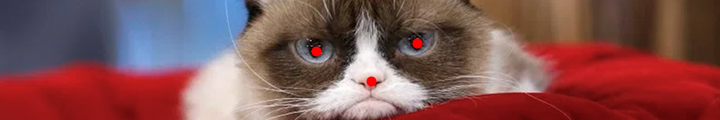

# Introduction

This notebook presents **Keypoint Detection** using a **CNN** on the [CAT](https://www.kaggle.com/crawford/cat-dataset) dataset.

**Resources**

* [Cat Hipsterizer](https://github.com/kairess/cat_hipsterizer) - inspiration for this notebook
* [CAT (Kaggle)](https://www.kaggle.com/crawford/cat-dataset) - dataset used in this notebook
* [CAT (original)](https://archive.org/details/CAT_DATASET) - internet archive link to original data

# Imports

In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.ImageDraw

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision

# Configuration

Point this to dataset directory, folder should contain CAT_00, CAT_01 and so on.

In [3]:
dataset_location = '/home/marcin/Datasets/cat-dataset/cats/'

# Helpers

Helper to draw keypoints on the image

In [4]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

In [5]:
def plot_images(indices, images, keypoints):
    """Plot bunch of images with keypoint overlay
    
    Params:
        indices - indices of images to plot, e.g. [0, 10, 20, ...]
        images - np.ndarray with raw images, [batch_size, width, height, channel]
        keypoints - np.ndarray with keypoints, [batch_size, num_keypoints, x, y]
    """
    _, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=[12,4])
    if len(indices) == 1: axes = [axes]

    for i, idx in enumerate(indices):
        img = PIL.Image.fromarray(images[idx])
        kps = keypoints[idx]
        axes[i].imshow(draw_keypoints(img, kps))
        axes[i].axis('off')
    
    plt.show()

# Load Dataset

In this section we:

* load images and keypoints from folder structure
* resize to 224x224 and save into numpy .npz file

Subfolders within dataset

In [6]:
folders_all = ['CAT_00', 'CAT_01', 'CAT_02', 'CAT_03', 'CAT_04', 'CAT_05', 'CAT_06']

Get paths to all images

In [7]:
def build_image_files_list(folders):
    image_files_list = []
    for folder in folders:
        wild_path = os.path.join(dataset_location, folder, '*.jpg')
        image_files_list.extend(sorted(glob.glob(wild_path)))
    return image_files_list

In [8]:
image_paths_all = build_image_files_list(folders_all)

In [9]:
print('Nb images:', len(image_paths_all))
image_paths_all[:3]

Nb images: 9997


['/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_000.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_005.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_008.jpg']

Helper to load keypoint data from *.cat* files

In [10]:
def load_keypoints(path):    
    """Load keypoints from .cat file
    
    The .cat file is a single-line text file in format: 'nb_keypoints x1, y1, x2, y2, ...'
    """
    with open(path, 'r') as f:
        line = f.read().split()  # [nb_keypoints, x1, y1, x2, y2, ...]
    keypoints_nb = int(line[0])  # int
    keypoints_1d = np.array(line[1:], dtype=int)  # np.ndarray, [x1, y1, x2, y2, ...]
    keypoints_xy = keypoints_1d.reshape((-1, 2))  # np.ndarray, [[x1, y1], [x2, y2], ...]
    assert keypoints_nb == len(keypoints_xy)
    assert keypoints_nb == 9                # always nine keypoints, eyes, nose, two ears
    return keypoints_xy                     # np.ndarray, [[x1, y1], [x2, y2], ...]

Open single image and load corresponding keypoints

In [11]:
example_path = image_paths_all[0]
img = PIL.Image.open(example_path)
kps = load_keypoints(example_path+'.cat')

Show example keypoints

In [12]:
display(kps)

array([[175, 160],
       [239, 162],
       [199, 199],
       [149, 121],
       [137,  78],
       [166,  93],
       [281, 101],
       [312,  96],
       [296, 133]])

Show example image

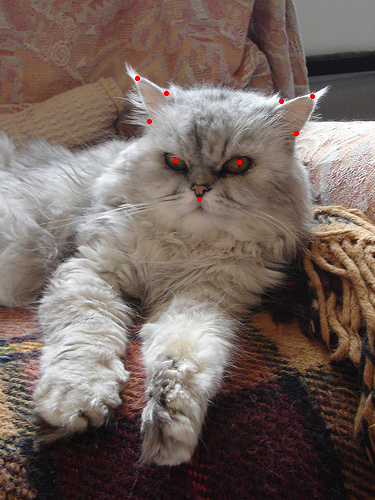

In [13]:
display(draw_keypoints(img.copy(), kps))

Helper to scale image and keypoints

In [14]:
def scale_img_kps(image, keypoints, target_size):
    width, height = image.size
    ratio_w = width / target_size
    ratio_h = height / target_size
    
    image_new = image.resize((target_size, target_size), resample=PIL.Image.LANCZOS)
    
    keypoints_new = np.zeros_like(keypoints)
    keypoints_new[range(len(keypoints_new)), 0] = keypoints[:,0] / ratio_w
    keypoints_new[range(len(keypoints_new)), 1] = keypoints[:,1] / ratio_h
    
    return image_new, keypoints_new

Test it

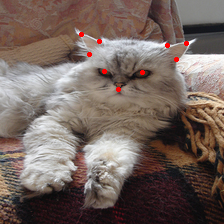

In [15]:
img2, kps2 = scale_img_kps(img, kps, target_size=224)
display(draw_keypoints(img2.copy(), kps2))

Helper to load and transform both input image and keypoints

In [16]:
def load_image_keypoints(image_path, keypoints_path, target_size):
    image = PIL.Image.open(image_path)
    keypoints = load_keypoints(keypoints_path)
    image_new, keypoints_new = scale_img_kps(image, keypoints, target_size)
    return image, keypoints, image_new, keypoints_new

Show couple more examples

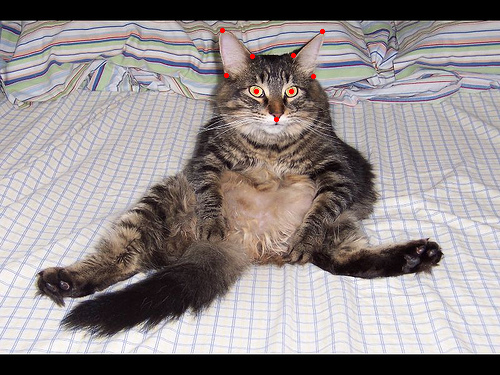

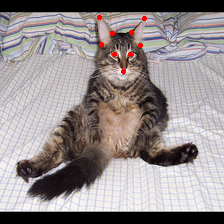

In [17]:
idx = 21

image, keypoints, image_new, keypoints_new = load_image_keypoints(
    image_paths_all[idx], image_paths_all[idx]+'.cat', target_size=224)
display(draw_keypoints(image.copy(), keypoints))
display(draw_keypoints(image_new.copy(), keypoints_new))

**Custom Generator**

In [18]:
class CatDataset(torch.utils.data.Dataset):
    def __init__(self, files_list, target_size, transforms=None,
                preprocess_keypts_function=None):
        """Custom dataset to use with torch dataloader
        
        Params:
            file_list - list with file paths
            target_size - target image size as integer (output img is square)
            transforms - torchvision.transforms.Compose object
            preprocess_keypts_function - 
                function to be called on keypoints mini batch
        """
        assert isinstance(files_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert transforms is None or \
               isinstance(transforms, torchvision.transforms.Compose)
        assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        
        self.files_list = np.array(files_list)  # for advanced indexing
        self.target_size = target_size
        self.transforms = transforms
        self.preprocess_keypts_function = preprocess_keypts_function
    
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, idx):
        file_path = self.files_list[idx]
        _, _, image, keypoints = load_image_keypoints(
            file_path, file_path+'.cat', target_size=self.target_size)
        
        if self.transforms is not None:
            image = self.transforms(image)
        if self.preprocess_keypts_function is not None:
            keypoints = self.preprocess_keypts_function(keypoints)
        
        return image, keypoints.astype(np.float32)

Split into train and validation sets

In [19]:
split = 8000
train_files = image_paths_all[:split]
valid_files = image_paths_all[split:]

Create generators

* images are normalised in the same way as dataset used for network pretraining (ImageNet)
* keypoints are normalised to range roughly -1..1

In [20]:
imgnet_mean = np.array([0.485, 0.456, 0.406])
imgnet_std  = np.array([0.229, 0.224, 0.225])

In [21]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(imgnet_mean, imgnet_std)
])

dataset_train = CatDataset(train_files, target_size=224, transforms=transforms,
    preprocess_keypts_function=lambda keypoints : (keypoints-112) / 112)
dataset_valid = CatDataset(valid_files, target_size=224, transforms=transforms,
    preprocess_keypts_function=lambda keypoints : (keypoints-112) / 112)

In [22]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True,
    num_workers=6, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid, batch_size=128, shuffle=False,
    num_workers=6, pin_memory=False)

Functions to reverse normalisation, so we can plot images

**Note:** _undo_preprocess_images_ is **not** exact reverse of image normalisation, hence images colour space looks a bit strange. This is ok for our purposes.

In [23]:
def undo_preprocess_images(images_batch):
    tmp = images_batch.detach().cpu().numpy().transpose(0, 2, 3, 1)
    tmp = (tmp * imgnet_std) + imgnet_mean
    tmp = (tmp * 255).astype(np.uint8)
    return tmp

In [24]:
def undo_preprocess_keypts(keypoints_batch, img_size):
    keypoints_batch = keypoints_batch.detach().cpu().numpy()
    return (keypoints_batch * (img_size // 2)) + (img_size // 2) 

Show couple samples

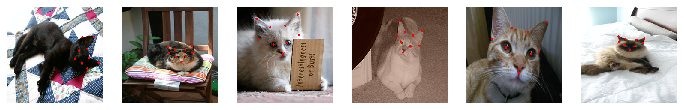

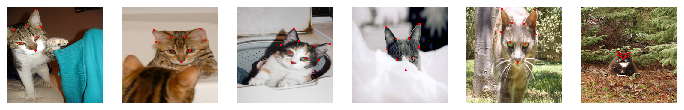

In [25]:
train_images, train_keypoints = iter(train_loader).next()
plot_images([5, 10, 15, 20, 25, 30],
            undo_preprocess_images(train_images),
            undo_preprocess_keypts(train_keypoints, img_size=224))

valid_images, valid_keypoints = iter(valid_loader).next()
plot_images([5, 10, 15, 20, 25, 30],
            undo_preprocess_images(valid_images),
            undo_preprocess_keypts(valid_keypoints, img_size=224))

# Train End-to-End

In [26]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(-1, *self.shape)

Get PyTorch device

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define model

In [28]:
model = torchvision.models.mobilenet_v2(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=18),
    Reshape(9, 2)
)
model.classifier = classifier
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, verbose=True)

Custom callback for plotting

In [29]:
class CallbackPlot:
    def __init__(self, train_images, valid_images):
        self.train_images = train_images
        self.valid_images = valid_images
    
    def on_epoch_end(self, batch, logs={}):
        _, _, iw, ih = self.train_images.shape
        
        model.eval()
        with torch.no_grad():
            predictions = model(self.train_images.to(device))
            plot_images([5, 10, 15, 20, 25, 30],
                        undo_preprocess_images(self.train_images),
                        undo_preprocess_keypts(predictions, iw))

            predictions = model(self.valid_images.to(device))
            plot_images([5, 10, 15, 20, 25, 30],
                        undo_preprocess_images(self.valid_images),
                        undo_preprocess_keypts(predictions, iw))

Show some cats before training. Most probably there won't be any keypoints shown

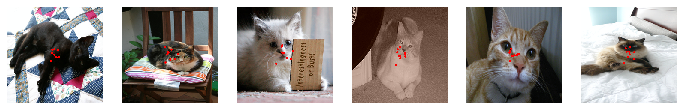

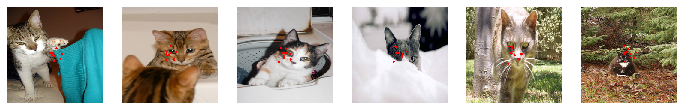

In [30]:
callback_plt = CallbackPlot(train_images, valid_images)
callback_plt.on_epoch_end(None)

In [31]:
def evaluate(model, data_loader):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            logits = model(images)
            loss = criterion(logits, targets)
            loss_sum += loss.item() * len(images)
    loss_res = loss_sum / len(data_loader.dataset)
    return loss_res

In [32]:
trace = {'epoch': [], 'tloss': [], 'vloss': []}

best_loss = float('inf')
stale_counter = 0

for epoch in range(50):
    
    time_start = time.time()
    
    #
    #   Train Model
    #
    model.train()
    tloss_sum = 0
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        tloss_sum += loss.item() * len(images)
    
    tloss = tloss_sum / len(train_loader.dataset)
    
    #
    #   Evaluate Model
    #
    vloss = evaluate(model, valid_loader)
    
    scheduler.step(vloss)
    
    #
    #   Logging
    #
    time_delta = time.time() - time_start
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), f'model.pth')
    
    trace['epoch'].append(epoch)
    trace['tloss'].append(tloss)
    trace['vloss'].append(vloss)
    
    print(f'Epoch: {epoch:3}     T/V Loss: {tloss:.4f} / {vloss:.4f}     '
          f'Time: {time_delta:.2f}s')
    
    
    
    # callback_plt.on_epoch_end(None)  # uncomment to see images

Epoch:   0     T/V Loss: 0.0285 / 0.0169     Time: 44.55s
Epoch:   1     T/V Loss: 0.0117 / 0.0258     Time: 46.08s
Epoch:   2     T/V Loss: 0.0100 / 0.0114     Time: 44.57s
Epoch:   3     T/V Loss: 0.0059 / 0.0070     Time: 45.06s
Epoch:   4     T/V Loss: 0.0049 / 0.0084     Time: 43.32s
Epoch:   5     T/V Loss: 0.0043 / 0.0067     Time: 45.95s
Epoch:   6     T/V Loss: 0.0041 / 0.0075     Time: 45.05s
Epoch:   7     T/V Loss: 0.0034 / 0.0063     Time: 45.66s
Epoch:   8     T/V Loss: 0.0034 / 0.0059     Time: 45.02s
Epoch:   9     T/V Loss: 0.0026 / 0.0057     Time: 45.05s
Epoch:  10     T/V Loss: 0.0027 / 0.0087     Time: 45.40s
Epoch:  11     T/V Loss: 0.0131 / 0.0150     Time: 46.02s
Epoch:  12     T/V Loss: 0.0076 / 0.0082     Time: 45.60s
Epoch:  13     T/V Loss: 0.0038 / 0.0056     Time: 44.26s
Epoch:  14     T/V Loss: 0.0028 / 0.0049     Time: 45.47s
Epoch:  15     T/V Loss: 0.0024 / 0.0049     Time: 46.26s
Epoch:  16     T/V Loss: 0.0022 / 0.0046     Time: 45.21s
Epoch:  17    

The final train loss should be around _0.0020_ and final validation loss around _0.0060_

Plot loss during training

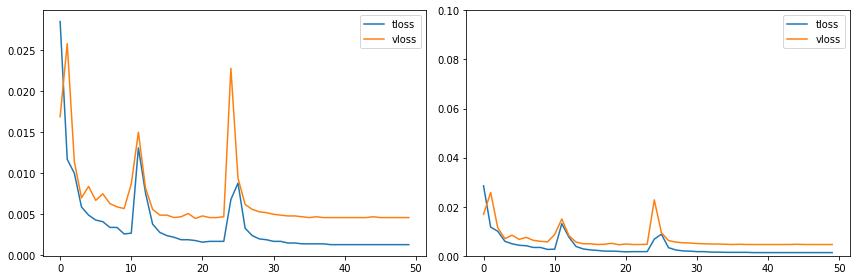

In [33]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.plot(trace['tloss'], label='tloss')
ax1.plot(trace['vloss'], label='vloss')
ax1.legend()

ax2.plot(trace['tloss'], label='tloss')
ax2.plot(trace['vloss'], label='vloss')
ax2.legend()
ax2.set_ylim(0, .1)

#ax3.plot(trace['lr'], label='lr')
#ax3.legend()

plt.tight_layout()
plt.show()

Show some cats from validation set - looks pretty good

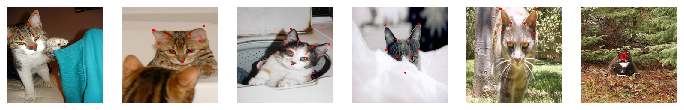

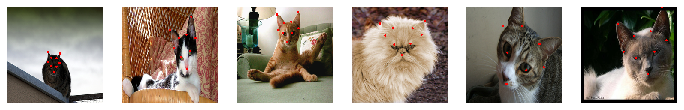

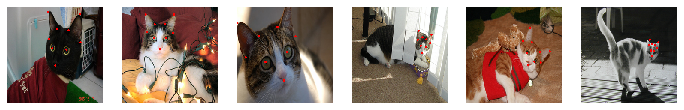

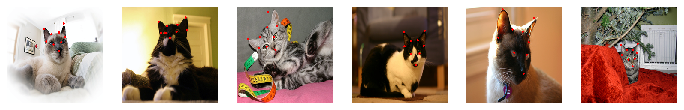

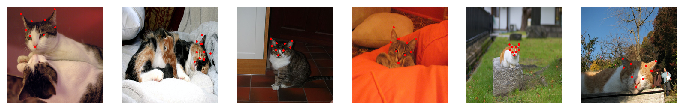

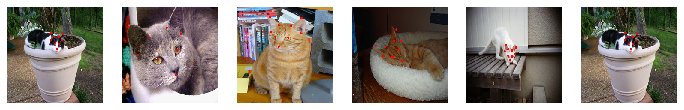

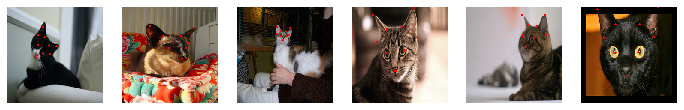

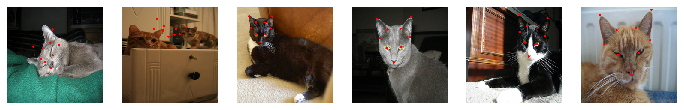

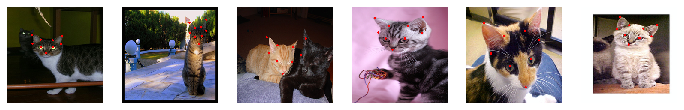

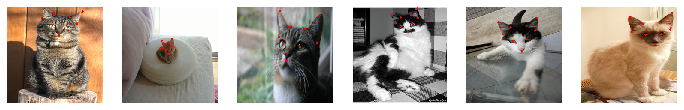

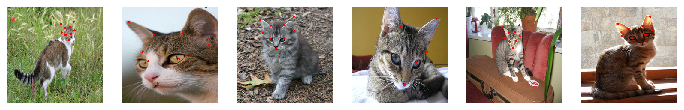

In [34]:
model.eval()
for i, (valid_images, _) in enumerate(valid_loader):
    with torch.no_grad():
        predictions = model(valid_images.to(device))
    plot_images([5, 10, 15, 20, 25, 30],
                undo_preprocess_images(valid_images),
                undo_preprocess_keypts(predictions, img_size=224))
    if i >= 10:
        break